In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
!pip install catboost

In [ ]:
import pandas as pd
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV
from scipy.stats import zscore
from sklearn.metrics import (
    accuracy_score, jaccard_score, f1_score, log_loss, mean_absolute_error,
    mean_squared_error, r2_score, precision_score, recall_score
)
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df = pd.read_csv('weatherAUS.csv')
print("Dataset Overview:")
print(df.head(15))

Dataset Overview:
          Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0   2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1   2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2   2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3   2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4   2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
5   2008-12-06   Albury     14.6     29.7       0.2          NaN       NaN   
6   2008-12-07   Albury     14.3     25.0       0.0          NaN       NaN   
7   2008-12-08   Albury      7.7     26.7       0.0          NaN       NaN   
8   2008-12-09   Albury      9.7     31.9       0.0          NaN       NaN   
9   2008-12-10   Albury     13.1     30.1       1.4          NaN       NaN   
10  2008-12-11   Albury     13.4     30.4       0.0          NaN       NaN   
11  2008-12-12   Albury     15.9     21.7     

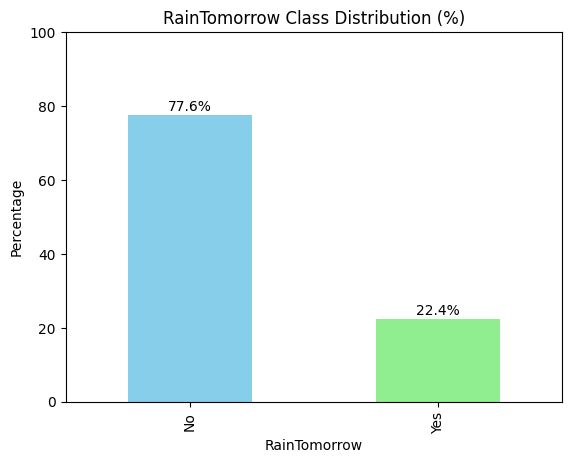

In [ ]:
rain_percent = df['RainTomorrow'].value_counts(normalize=True) * 100

# Plot
rain_percent.plot(kind='bar', color=['skyblue', 'lightgreen'])

# Add annotations
for i, value in enumerate(rain_percent):
    plt.text(i, value + 1, f'{value:.1f}%', ha='center')

# Labels and title
plt.title('RainTomorrow Class Distribution (%)')
plt.ylabel('Percentage')
plt.xlabel('RainTomorrow')
plt.ylim(0, 100)
plt.show()


In [ ]:
# one hot encoding
categorical_columns = ['RainToday', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df1 = pd.get_dummies(data=df, columns=categorical_columns)
print(df1.head(15))
print(df.isna().sum()) # miss value in the data

          Date Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
0   2008-12-01   Albury     13.4     22.9       0.6          NaN       NaN   
1   2008-12-02   Albury      7.4     25.1       0.0          NaN       NaN   
2   2008-12-03   Albury     12.9     25.7       0.0          NaN       NaN   
3   2008-12-04   Albury      9.2     28.0       0.0          NaN       NaN   
4   2008-12-05   Albury     17.5     32.3       1.0          NaN       NaN   
5   2008-12-06   Albury     14.6     29.7       0.2          NaN       NaN   
6   2008-12-07   Albury     14.3     25.0       0.0          NaN       NaN   
7   2008-12-08   Albury      7.7     26.7       0.0          NaN       NaN   
8   2008-12-09   Albury      9.7     31.9       0.0          NaN       NaN   
9   2008-12-10   Albury     13.1     30.1       1.4          NaN       NaN   
10  2008-12-11   Albury     13.4     30.4       0.0          NaN       NaN   
11  2008-12-12   Albury     15.9     21.7       2.2          NaN

In [ ]:
df1.replace(['No', 'Yes'], [0, 1], inplace=True)

df1.drop(['Date', 'Location'], axis=1, inplace=True)

df1 = df1.astype(float)

df1.dropna(inplace=True)

X = df1.drop(columns='RainTomorrow', axis=1)
Y = df1['RainTomorrow']

print(df1.head(15))
print(df1.columns)
print(df1.isna().sum())

      MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  WindGustSpeed  \
6049     17.9     35.2       0.0         12.0      12.3           48.0   
6050     18.4     28.9       0.0         14.8      13.0           37.0   
6052     19.4     37.6       0.0         10.8      10.6           46.0   
6053     21.9     38.4       0.0         11.4      12.2           31.0   
6054     24.2     41.0       0.0         11.2       8.4           35.0   
6055     27.1     36.1       0.0         13.0       0.0           43.0   
6056     23.3     34.0       0.0          9.8      12.6           41.0   
6057     16.1     34.2       0.0         14.6      13.2           37.0   
6058     19.0     35.5       0.0         12.0      12.3           48.0   
6059     19.7     35.5       0.0         11.0      12.7           41.0   
6060     20.9     37.8       0.0         12.8      13.2           30.0   
6061     23.9     39.1       0.0         13.8      12.1           39.0   
6062     24.9     41.2       0.0      

In [ ]:
# handling the outliers
for col in ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap the outliers to the bounds
    df[col] = df[col].clip(lower=lower_bound, upper=upper_bound)


In [ ]:
x_train1, x_test, y_train1, y_test = train_test_split(X, Y, test_size=0.1, random_state=10)

# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(x_train1, y_train1)

# Confirm new class balance
print("Before SMOTE:", y_train1.value_counts(normalize=True))
print("After SMOTE:", y_train_smote.value_counts(normalize=True))

x_train = X_train_smote
y_train = y_train_smote


Before SMOTE: RainTomorrow
0.0    0.781259
1.0    0.218741
Name: proportion, dtype: float64
After SMOTE: RainTomorrow
0.0    0.5
1.0    0.5
Name: proportion, dtype: float64


In [ ]:
print("\nLogistic Regression:")
LR = LogisticRegression(solver='liblinear')
LR.fit(x_train, y_train)
predictions = LR.predict(x_test)
LR_Accuracy_Score = accuracy_score(y_test, predictions)
LR_JaccardIndex = jaccard_score(y_test, predictions)
LR_F1_Score = f1_score(y_test, predictions)
LR_Log_Loss = log_loss(y_test, LR.predict_proba(x_test))
LR_Precision = precision_score(y_test, predictions)
LR_Recall = recall_score(y_test, predictions)
print(f"Accuracy: {LR_Accuracy_Score}")
print(f"Jaccard Index: {LR_JaccardIndex}")
print(f"F1 Score: {LR_F1_Score}")
print(f"Log Loss: {LR_Log_Loss}")
print(f"Precision: {LR_Precision}")
print(f"Recall: {LR_Recall}")




Logistic Regression:
Accuracy: 0.8108108108108109
Jaccard Index: 0.4803782505910166
F1 Score: 0.6489939316512296
Log Loss: 0.4159451282144532
Precision: 0.5527747551686616
Recall: 0.785769528228925


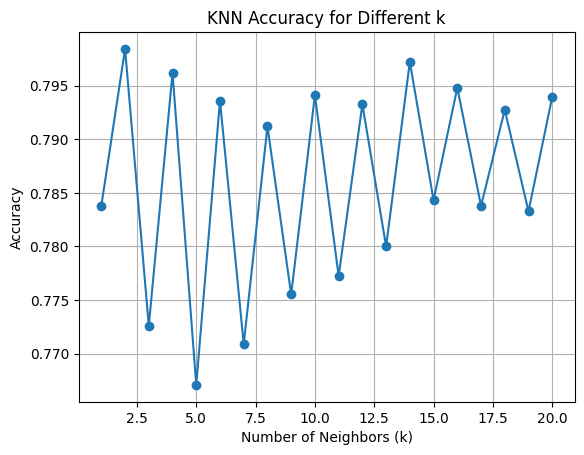


Best k: 2

Optimized K-Nearest Neighbors (KNN):
Accuracy: 0.7984
Jaccard Index: 0.3824
F1 Score: 0.5532
Precision: 0.5459
Recall: 0.5607


In [23]:
# Search for best k
k_range = range(1, 21)
accuracies = []

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    acc = accuracy_score(y_test, pred)
    accuracies.append(acc)

# Plot accuracy vs k
plt.plot(k_range, accuracies, marker='o')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy for Different k')
plt.grid(True)
plt.show()

# Get best k and retrain model
best_k = k_range[accuracies.index(max(accuracies))]
print(f"\nBest k: {best_k}")

# Final model with best k
KNN = KNeighborsClassifier(n_neighbors=best_k)
KNN.fit(x_train, y_train)
predictions = KNN.predict(x_test)

# Metrics
KNN_Accuracy_Score = accuracy_score(y_test, predictions)
KNN_JaccardIndex = jaccard_score(y_test, predictions)
KNN_F1_Score = f1_score(y_test, predictions)
KNN_Precision = precision_score(y_test, predictions)
KNN_Recall = recall_score(y_test, predictions)

print("\nOptimized K-Nearest Neighbors (KNN):")
print(f"Accuracy: {KNN_Accuracy_Score:.4f}")
print(f"Jaccard Index: {KNN_JaccardIndex:.4f}")
print(f"F1 Score: {KNN_F1_Score:.4f}")
print(f"Precision: {KNN_Precision:.4f}")
print(f"Recall: {KNN_Recall:.4f}")

In [ ]:
print("\nDecision Tree:")
Tree = DecisionTreeClassifier(criterion="entropy", max_depth=8)
Tree.fit(x_train, y_train)
predictions = Tree.predict(x_test)
Tree_Accuracy_Score = accuracy_score(y_test, predictions)
Tree_JaccardIndex = jaccard_score(y_test, predictions)
Tree_F1_Score = f1_score(y_test, predictions)
Tree_precision = precision_score(y_test, predictions)
Tree_recall = recall_score(y_test, predictions)
print(f"Accuracy: {Tree_Accuracy_Score}")
print(f"Jaccard Index: {Tree_JaccardIndex}")
print(f"F1 Score: {Tree_F1_Score}")
print(f"Precision: {Tree_precision}")
print(f"Recall: {Tree_recall}")


Decision Tree:
Accuracy: 0.8130487175073162
Jaccard Index: 0.44873096446700506
F1 Score: 0.6194814295725298
Precision: 0.5663036515054453
Recall: 0.6836813611755607


In [ ]:
print("\nSupport Vector Machine (SVM):")
SVM = LinearSVC()
SVM.fit(x_train, y_train)
predictions = SVM.predict(x_test)
SVM_Accuracy_Score = accuracy_score(y_test, predictions)
SVM_JaccardIndex = jaccard_score(y_test, predictions)
SVM_F1_Score = f1_score(y_test, predictions)
SVM_precision = precision_score(y_test, predictions)
SVM_recall = recall_score(y_test, predictions)
print(f"Accuracy: {SVM_Accuracy_Score}")
print(f"Jaccard Index: {SVM_JaccardIndex}")
print(f"F1 Score: {SVM_F1_Score}")
print(f"Precision: {SVM_precision}")
print(f"Recall: {SVM_recall}")



Support Vector Machine (SVM):
Accuracy: 0.8113272508176966
Jaccard Index: 0.48228625413320736
F1 Score: 0.6507329509241555
Precision: 0.5533875338753388
Recall: 0.7896365042536736


In [ ]:
print("\nRandom Forest:")
rf = RandomForestClassifier(n_estimators=100, max_depth=8, random_state=42)
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
rf_accuracy_score = accuracy_score(y_test, rf_pred)
rf_ji = jaccard_score(y_test, rf_pred)
rf_f1 = f1_score(y_test, rf_pred)
rf_pr = precision_score(y_test, rf_pred)
rf_re = recall_score(y_test, rf_pred)
print(f"Accuracy: {rf_accuracy_score}")
print(f"Jaccard Index: {rf_ji}")
print(f"F1 Score: {rf_f1}")
print(f"Precision: {rf_pr}")
print(f"Recall: {rf_re}")


Random Forest:
Accuracy: 0.817696677569289
Jaccard Index: 0.469438877755511
F1 Score: 0.6389362427548585
Precision: 0.5713414634146341
Recall: 0.7246713070378964


In [ ]:
print("\nXGBoost:")
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.1, 0.2]
}
search = RandomizedSearchCV(estimator=xgb, param_distributions=xgb_param_grid,
                            n_iter=5, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x_train, y_train)
print("Best XGBoost Params:", search.best_params_)
best_model = search.best_estimator_
xgb_pred = best_model.predict(x_test)

xgb_acc = accuracy_score(y_test, xgb_pred)
xgb_ji = jaccard_score(y_test, xgb_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
xgb_pr = precision_score(y_test, xgb_pred)
xgb_re = recall_score(y_test, xgb_pred)

print(f"Accuracy: {xgb_acc}")
print(f"Jaccard Index: {xgb_ji}")
print(f"F1 Score: {xgb_f1}")
print(f"Precision: {xgb_pr}")
print(f"Recall: {xgb_re}")


XGBoost:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best XGBoost Params: {'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01}
Accuracy: 0.8442072645894302
Jaccard Index: 0.48579545454545453
F1 Score: 0.6539196940726577
Precision: 0.6467473524962178
Recall: 0.6612529002320185


In [ ]:
print("\nLightGBM:")
lgb = LGBMClassifier()
lgb_param_grid = {
    'n_estimators': [100, 200],
    'num_leaves': [31, 50],
    'learning_rate': [0.01, 0.1]
}
search = RandomizedSearchCV(estimator=lgb, param_distributions=lgb_param_grid,
                            n_iter=5, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x_train, y_train)
print("Best LightGBM Params:", search.best_params_)
best_model = search.best_estimator_
lgbm_pred = best_model.predict(x_test)

lgbm_acc = accuracy_score(y_test, lgbm_pred)
lgbm_ji = jaccard_score(y_test, lgbm_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred)
lgbm_pr = precision_score(y_test, lgbm_pred)
lgbm_re = recall_score(y_test, lgbm_pred)
print(f"Accuracy: {lgbm_acc}")
print(f"Jaccard Index: {lgbm_ji}")
print(f"F1 Score: {lgbm_f1}")
print(f"Precision: {lgbm_pr}")
print(f"Recall: {lgbm_re}")


LightGBM:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
[LightGBM] [Info] Number of positive: 40845, number of negative: 40845
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044219 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16829
[LightGBM] [Info] Number of data points in the train set: 81690, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Best LightGBM Params: {'num_leaves': 31, 'n_estimators': 200, 'learning_rate': 0.01}
Accuracy: 0.8424857978998106
Jaccard Index: 0.4859550561797753
F1 Score: 0.6540642722117203
Precision: 0.639792899408284
Recall: 0.6689868522815159


In [ ]:
print("\nCatBoost:")
cat = CatBoostClassifier(silent=True)
cat_param_grid = {
    'iterations': [100, 200],
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1]
}

search = RandomizedSearchCV(estimator=cat, param_distributions=cat_param_grid,
                            n_iter=5, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)
search.fit(x_train, y_train)
print("Best CatBoost Params:", search.best_params_)
best_model = search.best_estimator_
cat_pred = best_model.predict(x_test)

cat_acc = accuracy_score(y_test, cat_pred)
cat_ji = jaccard_score(y_test, cat_pred)
cat_f1 = f1_score(y_test, cat_pred)
cat_pr = precision_score(y_test, cat_pred)
cat_re = recall_score(y_test, cat_pred)

print(f"Accuracy: {cat_acc}")
print(f"Jaccard Index: {cat_ji}")
print(f"F1 Score: {cat_f1}")
print(f"Precision: {cat_pr}")
print(f"Recall: {cat_re}")


CatBoost:
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best CatBoost Params: {'learning_rate': 0.01, 'iterations': 200, 'depth': 6}
Accuracy: 0.8331898777758651
Jaccard Index: 0.47536545749864645
F1 Score: 0.6444036697247706
Precision: 0.6131284916201117
Recall: 0.6790409899458624


In [24]:
print("\nSummary of Results:\n")
Report = {
    'Classification Algorithm': [ 'Logistic Regression','KNN (K=2)', 'Decision Tree', 'SVM', 'Random Forest', 'XGboost', 'Lightgbm','Catboost'],
    'Accuracy Score': [ LR_Accuracy_Score, KNN_Accuracy_Score, Tree_Accuracy_Score, SVM_Accuracy_Score, rf_accuracy_score, xgb_acc, lgbm_acc,cat_acc ],
    'Jaccard Score': [ LR_JaccardIndex, KNN_JaccardIndex, Tree_JaccardIndex, SVM_JaccardIndex, rf_ji, xgb_ji,lgbm_ji,cat_ji ],
    'F1 Score': [ LR_F1_Score, KNN_F1_Score, Tree_F1_Score, SVM_F1_Score, rf_f1, xgb_f1, lgbm_f1, cat_f1],
}
Report_df = pd.DataFrame(Report)
print(Report_df)


Summary of Results:

  Classification Algorithm  Accuracy Score  Jaccard Score  F1 Score
0      Logistic Regression        0.810811       0.480378  0.648994
1                KNN (K=2)        0.798416       0.382384  0.553224
2            Decision Tree        0.813049       0.448731  0.619481
3                      SVM        0.811327       0.482286  0.650733
4            Random Forest        0.817697       0.469439  0.638936
5                  XGboost        0.844207       0.485795  0.653920
6                 Lightgbm        0.842486       0.485955  0.654064
7                 Catboost        0.833190       0.475365  0.644404



Plotting the Results...



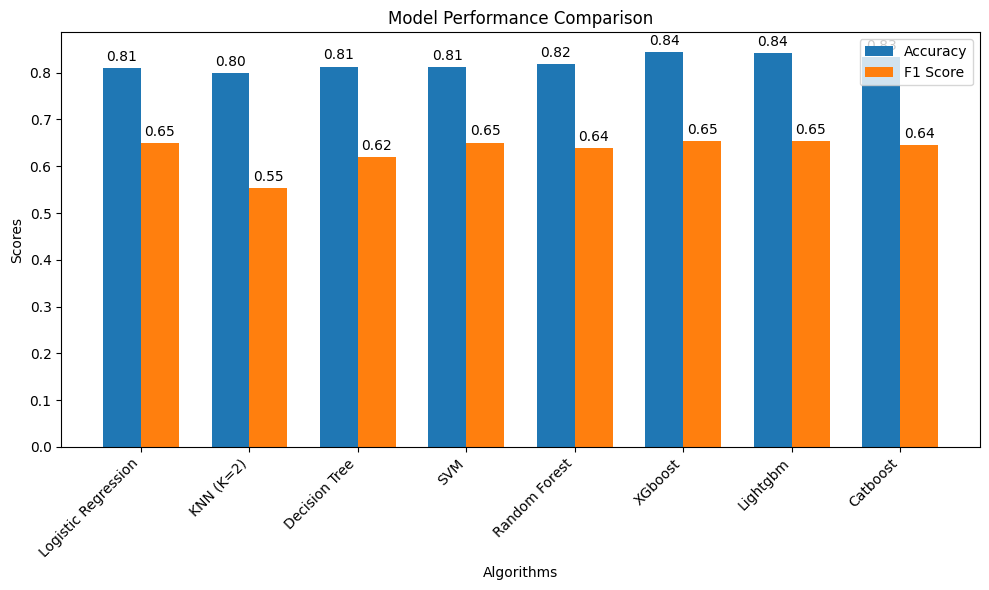

In [25]:
print("\nPlotting the Results...\n")
def plot_results(report):
    algorithms = report['Classification Algorithm']
    accuracy = report['Accuracy Score']
    f1_scores = report['F1 Score']

    x = np.arange(len(algorithms))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, accuracy, width, label='Accuracy')
    bars2 = ax.bar(x + width/2, f1_scores, width, label='F1 Score')

    ax.set_xlabel('Algorithms')
    ax.set_ylabel('Scores')
    ax.set_title('Model Performance Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(algorithms, rotation=45, ha='right')
    ax.legend()

    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    for bar in bars2:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_results(Report_df)